# Libraries and create tiles

In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys; import scanpy as sc
from pathlib import Path
from typing import Optional, Union
from anndata import AnnData
import pandas as pd
import stlearn
from typing import Optional, Union
from anndata import AnnData
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
import os
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import os
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score
from skimage.color import rgb2hed
%matplotlib inline
import pandas as pd
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lime
from sklearn.preprocessing import MinMaxScaler
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
import glob
import os
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.preprocessing import OneHotEncoder
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
import scipy as sp
from scipy import ndimage as ndi
from skimage.morphology import area_opening
import math; import copy


def tiling(
        adata: AnnData,
        out_path: Union[Path, str] = "./tiling",
        library_id: str = None,
        crop_size: int = 40,
        target_size: int = 299,
        verbose: bool = False,
        copy: bool = False,
) -> Optional[AnnData]:
    

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
            total=len(adata),
            desc="Tiling image",
            bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            # tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)#np.arange(len(pd.Series(adata))+1).astype(str).str.zfill(4)+1 + "-" +
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None

# Loading Visium Data and Image Tilling

In [2]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img


SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Sample1_un_norm, Sample2_un_norm = copy.copy(Sample1), copy.copy(Sample2)

for adata in [Sample1,Sample2,]:
    #Preprocessing
    st.pp.filter_genes(adata,min_cells=3)
    st.pp.log1p(adata)
    sc.pp.filter_cells(adata,min_counts=100)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    tiling(adata, TILE_PATH_, crop_size=299)
    
    #st.pp.extract_feature(adata)
    
"""Sample1.obs.iloc[:,4:] #Link_to_img
Sample2.obs.iloc[:,4:] #Link_to_img

Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes 
Sample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes"""

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]   


The morphology feature is added to adata.obsm['X_morphology']!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]  


The morphology feature is added to adata.obsm['X_morphology']!


'Sample1.obs.iloc[:,4:] #Link_to_img\nSample2.obs.iloc[:,4:] #Link_to_img\n\nSample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes \nSample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes'

In [ ]:
"""Sample1.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']].to_csv('Biomarker_Train.csv',index=False)
Sample2.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']].to_csv('Biomarker_Test.csv',index=False)"""

In [13]:
pd.DataFrame(Sample1.obsm['X_tile_feature']).to_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample1A.csv')

# FFPE

In [3]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "FFPE_Breast_Cancer"
Sample3 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"Visium_FFPE_Human_Breast_Cancer_image.tif", 0)
Sample3.uns["spatial"][SAMPLE]['images']["fulres"] = img


Sample3_un_norm = copy.copy(Sample3)
for adata in [Sample3,]:
     
    #st.pp.normalize_total(adata)
    st.pp.filter_genes(adata,min_cells=3)
    sc.pp.filter_cells(adata,min_counts=100)
    st.pp.log1p(adata)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    tiling(adata, TILE_PATH_, crop_size=299)
    #st.pp.extract_feature(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]  


The morphology feature is added to adata.obsm['X_morphology']!


In [14]:
pd.DataFrame(Sample3.obsm['X_tile_feature']).to_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample3_FFPE.csv')

# ST-Net

In [8]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/29ntw7sh4r-2/data")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


meta = pd.read_csv(BASE_PATH / "metadata.csv")
meta = meta.iloc[:21,:]

adata_list = []
for index,row in meta.iterrows():
    cm_path = BASE_PATH / row["stdata"].split(".gz")[0]
    spot_path = BASE_PATH / row["spots"].split(".gz")[0]
    img_path = BASE_PATH / row["img"]
    Sample = row["pateint"] +"_"+ row["replicate"]
    adata = st.read.file_table(cm_path)
    spot_df = pd.read_csv(spot_path,index_col=0)
    comm_index = pd.Series(list(set(spot_df.index).intersection(set(adata.obs_names))))
    adata = adata[comm_index]
    adata.obs["imagecol"] = spot_df["X"]
    adata.obs["imagerow"] = spot_df["Y"]
    st.add.image(adata, img_path, library_id=Sample)
    adata.obs["type"] = row["type"]
    
    st.pp.filter_genes(adata,min_cells=3)
    sc.pp.filter_cells(adata,min_counts=100)
    st.pp.log1p(adata)
    
    tiling(adata, out_path=TILE_PATH, crop_size=299)
    adata_list.append(adata)

adata_all = adata_list[0].concatenate(
    adata_list[1:],
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[list(d.keys())[0]
                      for d in[adata_list[i].uns["spatial"] 
                      for i in range(len(adata_list))
                              ]
                     ],
)

Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Tiling image:   0%|           [ time left: ? ]

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Tiling image:   0%|           [ time left: ? ]

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Tiling image:   0%|           [ time left: ? ]

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Tiling image:   0%|           [ time left: ? ]

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Tiling image:   0%|           [ time left: ? ]

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Tiling image:   0%|           [ time left: ? ]

Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


In [9]:
ems_df = pd.read_csv("D:/onkar/Projects/Project_Spt.Transcriptomics/29ntw7sh4r-2/data/ensembl.tsv", sep="\t")
a = adata_all.var_names.intersection(ems_df["Ensembl ID(supplied by Ensembl)"])
b = ems_df["Approved symbol"][ems_df["Ensembl ID(supplied by Ensembl)"].isin(a)]
var_dic = dict(zip(a,b))
adata_all = adata_all[:,a].copy()
adata_all.var_names = adata_all.var_names.map(var_dic)
adata_all.to_df()

,A1BG,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
9x26-BC23209_C1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
15x13-BC23209_C1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.098612,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
6x22-BC23209_C1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.098612,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
10x14-BC23209_C1,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.693147,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.693147,0.0
19x12-BC23209_C1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26x21-BC23269_D1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.000000,0.0
8x23-BC23269_D1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.693147,0.0
22x23-BC23269_D1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
12x16-BC23269_D1,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.693147,0.693147,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.693147,0.0


In [4]:
BASE_PATH_test = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/29ntw7sh4r-2/data")
TILE_PATH_test = BASE_PATH_test / "tiles_test"
TILE_PATH_test.mkdir(parents=True, exist_ok=True)


meta_test = pd.read_csv(BASE_PATH_test / "metadata.csv")
meta_test = meta_test.iloc[21:27,:]

adata_list_test = []
for index,row in meta_test.iterrows():
    cm_path_test = BASE_PATH_test / row["stdata"].split(".gz")[0]
    spot_path_test = BASE_PATH_test / row["spots"].split(".gz")[0]
    img_path_test = BASE_PATH_test / row["img"]
    Sample_test = row["pateint"] +"_"+ row["replicate"]
    adata_test = st.read.file_table(cm_path_test)
    spot_df_test = pd.read_csv(spot_path_test,index_col=0)
    comm_index_test = pd.Series(list(set(spot_df_test.index).intersection(set(adata_test.obs_names))))
    adata_test = adata_test[comm_index_test]
    adata_test.obs["imagecol"] = spot_df_test["X"]
    adata_test.obs["imagerow"] = spot_df_test["Y"]
    st.add.image(adata_test, img_path_test, library_id=Sample_test)
    adata_test.obs["type"] = row["type"]
    
    st.pp.filter_genes(adata_test,min_cells=3)
    sc.pp.filter_cells(adata_test,min_counts=100)
    st.pp.log1p(adata_test)
    
    tiling(adata_test, out_path=TILE_PATH_test, crop_size=299)
    adata_list_test.append(adata_test)

adata_all_test = adata_list_test[0].concatenate(
    adata_list_test[1:],
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[list(d.keys())[0]
                      for d in[adata_list_test[i].uns["spatial"] 
                      for i in range(len(adata_list_test))
                              ]
                     ],
)

Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


In [7]:
ems_df_test = pd.read_csv("D:/onkar/Projects/Project_Spt.Transcriptomics/29ntw7sh4r-2/data/ensembl.tsv", sep="\t")
a_test = adata_all_test.var_names.intersection(ems_df_test["Ensembl ID(supplied by Ensembl)"])
b_test = ems_df_test["Approved symbol"][ems_df_test["Ensembl ID(supplied by Ensembl)"].isin(a)]
var_dic_test = dict(zip(a_test,b_test))
adata_all_test = adata_all_test[:,a_test].copy()
adata_all_test.var_names = adata_all_test.var_names.map(var_dic_test)
adata_all_test.to_df()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,A1BG,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
15x13-BC23272_D2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
28x26-BC23272_D2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.693147,0.000000,0.0,0.0,0.000000,0.0
10x14-BC23272_D2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.693147,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
10x9-BC23272_D2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,1.386294,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3x21-BC23272_D2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.693147,0.000000,0.000000,0.0,0.0,1.098612,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26x21-BC23277_E2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.693147,0.0
8x23-BC23277_E2,0.0,0.000000,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,1.098612,0.000000,0.0,0.0,0.000000,0.0
22x23-BC23277_E2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.098612,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
12x16-BC23277_E2,0.0,1.098612,0.693147,0.0,0.0,0.0,1.386294,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.693147,0.693147,0.0,0.0,0.000000,0.0


## ResNet50 Features

In [52]:
import os; import pandas as pd; import numpy as np
import PIL; from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import os; import glob
from PIL import Image; import matplotlib.pyplot as plt; 
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16, ResNet50, inception_v3, DenseNet121, InceptionResNetV2, MobileNetV2
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
import warnings

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"
def ResNet50_features_train(train, pre_model):
 
    x_scratch_train = []
    for imagePath in train:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_train.append(image)
        
    x_train = np.vstack(x_scratch_train)
    features_train = pre_model.predict(x_train, batch_size=32)
    features_flatten_train = features_train.reshape((features_train.shape[0], 1280))
    features_flatten_train = pd.DataFrame(features_flatten_train)
    features_flatten_train.index = Sample1.obsm.to_df().index
    Sample1.obsm["Resnet50_Train_Features"] = features_flatten_train

def ResNet50_features_test(test, pre_model):
    
    x_scratch_test = []
    for imagePath in test:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_test.append(image)

    x_test = np.vstack(x_scratch_test)
    features_test = pre_model.predict(x_test, batch_size=32)
    features_flatten_test = features_test.reshape((features_test.shape[0], 1280))
    features_flatten_test = pd.DataFrame(features_flatten_test)
    features_flatten_test.index = Sample2.obsm.to_df().index
    Sample2.obsm["Resnet50_Test_Features"] = features_flatten_test
    
train = Sample1.obs["tile_path"]
test = Sample2.obs["tile_path"]
model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(299,299, 3), pooling="avg")
ResNet50_features_train(train, model)
ResNet50_features_test(test, model)

In [53]:
wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/"

Sample2.obsm["Resnet50_Test_Features"].to_csv(wd+"I_Resnet_log_norm_test.csv")
Sample1.obsm["Resnet50_Train_Features"].to_csv(wd+"I_Resnet_log_norm_train.csv")

### FFPE

In [3]:
import os; import pandas as pd; import numpy as np
import PIL; from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import os; import glob
from PIL import Image; import matplotlib.pyplot as plt; 
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16, ResNet50, inception_v3, DenseNet121
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
import warnings

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/"

def ResNet50_features_test(test, pre_model):
    
    x_scratch_test = []
    for imagePath in test:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_test.append(image)

    x_test = np.vstack(x_scratch_test)
    features_test = pre_model.predict(x_test, batch_size=32)
    features_flatten_test = features_test.reshape((features_test.shape[0], 2048))
    features_flatten_test = pd.DataFrame(features_flatten_test)
    features_flatten_test.index = Sample3.obsm.to_df().index
    Sample3.obsm["Resnet50_Test_Features"] = features_flatten_test
    
#train = Sample1.obs["tile_path"]
test = Sample3.obs["tile_path"]
model = ResNet50(weights="imagenet", include_top=False, input_shape=(299,299, 3), pooling="avg")
#ResNet50_features_train(train, model)
ResNet50_features_test(test, model)

In [4]:
Sample3.obsm["Resnet50_Test_Features"].to_csv(wd+'Filtered_FFPE.csv')

## ST-Net

In [10]:
import os; import pandas as pd; import numpy as np
import PIL; from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import os; import glob
from PIL import Image; import matplotlib.pyplot as plt; 
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16, ResNet50, inception_v3, DenseNet121
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
import warnings

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"

def ResNet50_features_train(test, pre_model):
    
    x_scratch_test = []
    for imagePath in test:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_test.append(image)

    x_test = np.vstack(x_scratch_test)
    features_test = pre_model.predict(x_test, batch_size=32)
    features_flatten_test = features_test.reshape((features_test.shape[0], 2048))
    features_flatten_test = pd.DataFrame(features_flatten_test)
    features_flatten_test.index = adata_all.obsm.to_df().index
    adata_all.obsm["Resnet50_Train_Features"] = features_flatten_test
    
train = adata_all.obs["tile_path"]
model = ResNet50(weights="imagenet", include_top=False, input_shape=(299,299, 3), pooling="avg")
ResNet50_features_train(train, model)

In [12]:
wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"

def ResNet50_features_test(test, pre_model):
    
    x_scratch_test = []
    for imagePath in test:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_test.append(image)

    x_test = np.vstack(x_scratch_test)
    features_test = pre_model.predict(x_test, batch_size=32)
    features_flatten_test = features_test.reshape((features_test.shape[0], 2048))
    features_flatten_test = pd.DataFrame(features_flatten_test)
    features_flatten_test.index = adata_all_test.obsm.to_df().index
    adata_all_test.obsm["Resnet50_Test_Features"] = features_flatten_test
    
#train = Sample1.obs["tile_path"]
test = adata_all_test.obs["tile_path"]
ResNet50_features_test(test, model)

In [13]:
adata_all.obsm["Resnet50_Train_Features"].to_csv(wd+'/Filtered_ST-Net_train.csv')
adata_all_test.obsm["Resnet50_Test_Features"].to_csv(wd+'/Filtered_ST-Net_test.csv')

## Cancer vs Non-Cancer Spot

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray
from os import listdir
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering


def Clusters(Sample1_tiles, Sample1, Sample2_tiles, Sample2, model):
    
    Sample1_to_df = Sample1.to_df().reset_index(drop=True)
    Sample1_to_df.drop([col for col, val in Sample1_to_df.sum().iteritems() if val < 20000], axis=1, inplace=True)

    Sample2_to_df = Sample2.to_df().reset_index(drop=True)
    Sample2_to_df.drop([col for col, val in Sample2_to_df.sum().iteritems() if val < 20000], axis=1, inplace=True)
    
    photos_Sample1, photos_Sample2 =list(), list()
    for filename in Sample1_tiles:
            # load image
            photo = load_img(filename, target_size=(140,140))
            # convert to numpy array
            photo = img_to_array(photo, dtype='uint8')
            # store
            photos_Sample1.append(photo)
    
    Img_Sample1 = asarray(photos_Sample1, dtype='uint8')
    Img_Sample1 = pd.DataFrame(Img_Sample1.reshape(Img_Sample1.shape[0],58800))
    result_Sample1 = pd.concat([Img_Sample1, Sample1_to_df], axis=1)
    y_hc_Sample1 = pd.DataFrame(index = Sample1.obs.index)
    y_hc_Sample1["Cluster"] = model.fit_predict(result_Sample1)
    Sample1.obs["Cluster"] = y_hc_Sample1["Cluster"]
    #y_hc_Sample1["Cluster"].to_csv('C:/Users/Onkar/Cluster_train.csv')

    for filename in Sample2_tiles:
            # load image
            photo = load_img(
                filename, target_size=(140,140))
            # convert to numpy array
            photo = img_to_array(photo, dtype='uint8')
            # store
            photos_Sample2.append(photo)

    Img_Sample2 = asarray(photos_Sample2, dtype='uint8')
    Img_Sample2 =  pd.DataFrame(Img_Sample2.reshape(Img_Sample2.shape[0],58800))
    result_Sample2 =  pd.concat([Img_Sample2, Sample2_to_df], axis=1)
    y_hc_Sample2 = pd.DataFrame(index = Sample2.obs.index)
    y_hc_Sample2["Cluster"] = model.fit_predict(result_Sample2)
    Sample2.obs["Cluster"] = y_hc_Sample2["Cluster"]
    #y_hc_Sample2["Cluster"].to_csv('C:/Users/Onkar/Cluster_test.csv')
    
model = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
Sample1_tiles = Sample1.obs["tile_path"]
Sample1 = Sample1
Sample2_tiles = Sample2.obs["tile_path"]
Sample2 = Sample2

Clusters(Sample1_tiles, Sample1, Sample2_tiles, Sample2, model)

### FFPE

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray
from os import listdir
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering


def Clusters(Sample3_tiles, Sample3, model):
    
    Sample3_to_df = Sample3.to_df().reset_index(drop=True)
    Sample3_to_df.drop([col for col, val in Sample3_to_df.sum().iteritems() if val < 20000], axis=1, inplace=True)
    
    photos_Sample3 = list()
    for filename in Sample3_tiles:
            # load image
            photo = load_img(filename, target_size=(140,140))
            # convert to numpy array
            photo = img_to_array(photo, dtype='uint8')
            # store
            photos_Sample3.append(photo)
    
    Img_Sample1 = asarray(photos_Sample3, dtype='uint8')
    Img_Sample1 = pd.DataFrame(Img_Sample1.reshape(Img_Sample1.shape[0],58800))
    result_Sample1 = pd.concat([Img_Sample1, Sample3_to_df], axis=1)
    y_hc_Sample1 = pd.DataFrame(index = Sample3.obs.index)
    y_hc_Sample1["Cluster"] = model.fit_predict(result_Sample1)
    Sample3.obs["Cluster"] = y_hc_Sample1["Cluster"]
    #y_hc_Sample1["Cluster"].to_csv('C:/Users/Onkar/Cluster_train.csv')

    
model = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
Sample3_tiles = Sample3.obs["tile_path"]
Sample3 = Sample3


Clusters(Sample3_tiles, Sample3, model)

## Cancer and Non-Cancer Spots Visualisation in Visualization.py

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1.obs[Sample1.obs['Cluster'] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Sample1.obs[Sample1.obs['Cluster'] == 1]
    Spot_vals1=Spot_vals1.values

    x = Spot_vals0[:,4].astype('int64')
    y = Spot_vals0[:,5].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()
    
    x1 = Spot_vals1[:,4].astype('int64')
    y1 = Spot_vals1[:,5].astype('int64')
    box1 = (x1,y1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()

    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 50,(255,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 50,(0,255,0), -1)
    cv2.imwrite(wd+"Cancer_vs_Non-Cancer_New_trial_train.png",image)

image = cv2.imread("tiles/block1/V1_Breast_Cancer_Block_A_Section_1_image.tif") 
Sample1 = Sample1
Visualise(image, Sample1)

## FFPE

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1.obs[Sample1.obs['Cluster'] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Sample1.obs[Sample1.obs['Cluster'] == 1]
    Spot_vals1=Spot_vals1.values
    Spot_vals2=Sample1.obs[Sample1.obs['Cluster'] == 2]
    Spot_vals2=Spot_vals2.values

    x = Spot_vals0[:,4].astype('int64')
    y = Spot_vals0[:,5].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()
    
    x1 = Spot_vals1[:,4].astype('int64')
    y1 = Spot_vals1[:,5].astype('int64')
    box1 = (x1,y1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()
    
    x2 = Spot_vals2[:,4].astype('int64')
    y2 = Spot_vals2[:,5].astype('int64')
    box2 = (x2,y2)
    numpy_array2 = np.array(box2)
    transpose2 = numpy_array2.T
    box2 = transpose2.tolist()

    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 50,(255,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 50,(0,255,0), -1)
    for i in range(0,len(box2)):
        image=cv2.circle(image, tuple(box2[i]), 50,(0,0,255), -1)
    cv2.imwrite(wd+"Cancer_vs_Non-Cancer_FFPE-2_"+gene+".png",image)

image = cv2.imread(wd+"FFPE_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_image.tif") 
gene = "TTLL12"
Sample3 = Sample3
Sample3.obs["Cluster"] = Sample3.to_df()[[gene]].apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
Visualise(image, Sample3)

## ST-Net

## UMAP Non-Cancer vs Cancer - Resnet50 Features - model.py

In [ ]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import umap.plot

def Umap_points(resnet_features, label):
    
    mapper = umap.UMAP().fit(resnet_features)
    return umap.plot.points(mapper, labels=label, theme='fire', background='black')

resnet_features =Sample1.obsm["Resnet50_Train_Features"].values
label = Sample1.obs["Cluster"].values
Umap_points(resnet_features, label)

## Cancer and Non-Cancer Spot Prediction by Biomarkers - model.py

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import shap
import numpy as np
import lime
import lime.lime_tabular
import joblib

def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

def Can_pred_Biomarker(Biomarkers_train, Cluster_train, Biomarkers_test, tree_model):
    X_train, X_test, y_train, y_test = train_test_split(Biomarkers_train, Cluster_train, test_size = 0.15, random_state = 0, stratify=Cluster_train)
    clf = tree_model
    clf.fit(X_train, y_train)
    return clf, clf.predict(Biomarkers_test), joblib.dump(clf, wd+'Cancer_vs_Non-Cancer_clf.pkl')

def Shapley_plot(Biomarkers_train, Biomarkers_test, clf):
    shap.initjs()
    explainer = shap.TreeExplainer(clf, Biomarkers_train)
    shap_values = explainer.shap_values(Biomarkers_test)
    return shap.summary_plot(shap_values, Biomarkers_test)

def Lime_plot(Biomarkers_train):

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(Biomarkers_train),
                        feature_names=Biomarkers_train.columns, 
                        class_names=['0','1'],                            
                        verbose=True, mode='classification')
    return explainer


    
Biomarkers_train = Sample1.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']]
Cluster_train = Sample1.obs["Cluster"] #pd.read_csv('C:/Users/Onkar/Cluster_train.csv').iloc[:,1:] #
Biomarkers_test = Sample2.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']]
Cluster_test = Sample2.obs["Cluster"] #pd.read_csv('C:/Users/Onkar/Cluster_test.csv').iloc[:,1:] #
tree_model = lgb.LGBMClassifier()

clf, y_pred_test, saved_model = Can_pred_Biomarker(Biomarkers_train, Cluster_train, Biomarkers_test, tree_model)
cm = confusion_matrix(Cluster_test, y_pred_test)
print('Confusion matrix\n\n', cm)
multiclass_roc_score = multiclass_roc_auc_score(Cluster_test, y_pred_test, average="weighted")
print('AUROC-Score:', multiclass_roc_score)

Shapley_plot(Biomarkers_train, Biomarkers_test, clf)
explainer = Lime_plot(Biomarkers_train)
exp = explainer.explain_instance(Biomarkers_test.iloc[2], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True) 

# AUROC Score LGBM 3-Class Classification of Gene Expression - model.py

In [4]:
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder; from sklearn.model_selection import train_test_split
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score; from sklearn.neighbors import KNeighborsClassifier
import pandas as pd; import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder; from sklearn.model_selection import train_test_split
from sklearn import preprocessing; from sklearn.linear_model import LogisticRegression
import shap; import numpy as np; import joblib

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"
    
def three_class_auroc(X, test_X, Y, test_Y, number_of_genes, model):
    
    def multiclass_roc_auc_score(truth, pred, average="macro"):
        lb = LabelBinarizer()
        lb.fit(truth)
        truth = lb.transform(truth)
        pred = lb.transform(pred)
        return roc_auc_score(truth, pred, average=average)

    Y=Y.iloc[:,:number_of_genes]
    genes = Y.columns
    MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
    Y = MinMax_scaler_y.fit_transform(Y) 
    Y = pd.DataFrame(data=Y)
    Y=Y.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))
    
    test_Y=test_Y.iloc[:,:number_of_genes]
    test_Y=MinMax_scaler_y.transform(test_Y)
    test_Y=pd.DataFrame(data=test_Y)
    test_Y=test_Y.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))
    
    
    clf = MultiOutputClassifier(model).fit(X, Y)
    y_pred_test = clf.predict_proba(test_X)
    y_pred_test = np.array(y_pred_test)
    
    
    y_pred_test = clf.predict_proba(test_X)
    y_pred_test = np.array(y_pred_test)

    y_pred_test_2 = clf.predict(test_X)
    y_pred_test_2 = pd.DataFrame(y_pred_test_2)

    result_ovr =[]; multi_auroc = []
    for col in test_Y:
        #score_ovr =  roc_auc_score(test_Y[col], y_pred_test[col], multi_class='ovr', average='weighted')
        score_multi = roc_auc_score(test_Y[col], y_pred_test_2[col])
        #result_ovr.append(score_ovr)
        multi_auroc.append(score_multi)
    
    result = pd.DataFrame()
    result["Multi_class_defined_auroc"] = multi_auroc
    #result["One_vs_rest"] = result_ovr
    result.index = genes
        
    return result.to_csv('AUROC-LGBM_200genes-2.csv'), joblib.dump(clf, 'ResNet50-LGBM_200genes-2.pkl')

X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_train.csv')#Sample1.obsm["Resnet50_Train_Features"]#
X = X.iloc[:,1:]
test_X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_test.csv')#Sample2.obsm["Resnet50_Test_Features"]#
test_X = test_X.iloc[:,1:]
Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
test_Y = Sample2.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
number_of_top_genes = 200
model = lgb.LGBMClassifier()

res = three_class_auroc(X, test_X, Y, test_Y, number_of_top_genes, model)
res

(None, ['ResNet50-LGBM_200genes-2.pkl'])

## Biomarker LGBM

In [73]:
from sklearn.multioutput import MultiOutputClassifier; import lightgbm as lgb
import pandas as pd; import shap; import numpy as np; import joblib
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"
    
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


biomarker_list_1 = ['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1',"PABPC1", "GNAS", "HSP90AB1", "TFF3",
                      "ATP1A1", "B2M", "FASN", "ACTG1", "HLA-B"]

X_1 = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_train.csv')
X_1 = X_1.iloc[:,1:]
test_X_1 = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_test.csv')
test_X_1 = test_X_1.iloc[:,1:]
Y_1 = Sample1.to_df()
test_Y_1 = Sample2.to_df()
model = MLPClassifier(alpha=1, max_iter=7500)#lgb.LGBMClassifier()#

    
MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))

Y_1 = Y_1[biomarker_list_1]
Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
Y_1 = pd.DataFrame(data=Y_1)
Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.1, 0.5, 1.1], labels = [0, 1]))
#Y_1 = Y_1.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))

test_Y_1 = test_Y_1[biomarker_list_1]
test_Y_1 = MinMax_scaler_y_1.transform(test_Y_1)
test_Y_1 = pd.DataFrame(data=test_Y_1)
test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.5, 0.5, 1.1], labels = [0, 1]))
#test_Y = test_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
test_Y_1 = test_Y_1.fillna(0)

Y_1 = Y_1.astype('int64')
test_Y_1 = test_Y_1.astype('int64')

In [74]:
clf_1 = MultiOutputClassifier(model).fit(X_1, Y_1)
#joblib.dump(clf, wd+'ResNet50-LGBM_biomarker_gene.pkl')

In [75]:
y_pred_test_1 = clf_1.predict_proba(test_X_1)
y_pred_test_1 = np.array(y_pred_test_1)

y_pred_test_2_1 = clf_1.predict(test_X_1)
y_pred_test_2_1 = pd.DataFrame(y_pred_test_2_1)

In [76]:
auroc_1 = []
for col in test_Y_1:
    score_multi_1 = roc_auc_score(test_Y_1[col], y_pred_test_2_1[col])#, average='weighted'
    auroc_1.append(score_multi_1)
    
result_1 = pd.DataFrame()
result_1["auroc"] = auroc_1
result_1.index = biomarker_list_1
result_1

,auroc
COX6C,0.714503
MALAT1,0.534625
TTLL12,0.547481
PGM5,0.499872
KRT5,0.499494
LINC00645,0.516396
SLITRK6,0.579038
CPB1,0.516745
PABPC1,0.721642
GNAS,0.721810


In [90]:
result_1.sort_values("auroc", ascending=False)

,auroc
HSP90AB1,0.742070
GNAS,0.721810
PABPC1,0.721642
COX6C,0.714503
FASN,0.688059
ACTG1,0.671417
TFF3,0.643042
HLA-B,0.616278
ATP1A1,0.605532
B2M,0.579554


In [ ]:
#result.to_csv(wd+"biomarker_genes_aurocs-2.csv")
#joblib.dump(clf, wd+'ResNet50-LGBM_biomarker_gene.pkl')

# Family of Genes

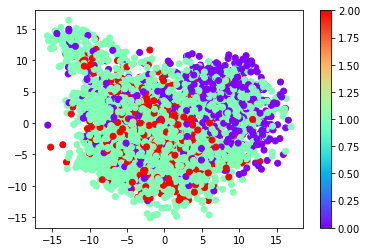

In [43]:
from sklearn.decomposition import PCA
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

X = Sample1.obsm["Resnet50_Train_Features"]#pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_train.csv')
#X = X.iloc[:,1:]
test_X = Sample2.obsm["Resnet50_Test_Features"]#pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_test.csv')
#test_X = test_X.iloc[:,1:]
Y = Sample1.to_df()
test_Y = Sample2.to_df()

filter_col_train = [col for col in Y if col.startswith('HLA')]
filter_col_test = [col for col in test_Y if col.startswith('HLA')]
intersection = set.intersection(set(filter_col_train), set(filter_col_test))
MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))

Y = Y[intersection]
Y = np.array(Y.sum(axis = 1)).reshape(-1,1)
Y = MinMax_scaler_y.fit_transform(Y) 
Y = pd.DataFrame(data=Y)
Y = Y.apply(lambda x: pd.cut(x, bins=[-0.1, 0.33, 0.66, 1.05], labels = [0, 1, 2]))

test_Y = test_Y[intersection]
test_Y = np.array(test_Y.sum(axis = 1)).reshape(-1,1)
test_Y = MinMax_scaler_y.transform(test_Y)
test_Y = pd.DataFrame(data=test_Y)
test_Y = test_Y.apply(lambda x: pd.cut(x, bins=[-0.1, 0.33, 0.66, 1.05], labels = [0, 1, 2]))

test_X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_test.csv')
test_X = test_X.iloc[:,1:]

pca = PCA(0.99)
pca = pca.fit_transform(test_X)
pca = pd.DataFrame(pca)
plt.scatter(pca.iloc[:,0:1], pca.iloc[:,1:2], c=test_Y, cmap="rainbow") 
plt.colorbar()

In [ ]:
from sklearn.multioutput import MultiOutputClassifier; import lightgbm as lgb
import pandas as pd; import shap; import numpy as np; import joblib
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split; from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier; from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_hist_gradient_boosting; from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

#ATP1, HLA, LINC006
wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"
    
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_train.csv')#Sample1.obsm["Resnet50_Train_Features"]#
X = X.iloc[:,1:]
test_X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_test.csv')#Sample2.obsm["Resnet50_Test_Features"]#
test_X = test_X.iloc[:,1:]
Y = Sample1.to_df()
test_Y = Sample2.to_df()
model = MLPClassifier(alpha=1, max_iter=5000)#GaussianProcessClassifier(1.0 * RBF(1.0))#lgb.LGBMClassifier()#LogisticRegression(max_iter=10000, multi_class='ovr')

filter_col_train = [col for col in Y if col.startswith('COX')]
filter_col_test = [col for col in test_Y if col.startswith('COX')]
intersection = set.intersection(set(filter_col_train), set(filter_col_test))
MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))

Y = Y[intersection]
Y = np.array(Y.sum(axis = 1)).reshape(-1,1)
Y = MinMax_scaler_y.fit_transform(Y) 
Y = pd.DataFrame(data=Y)
Y = Y.apply(lambda x: pd.cut(x, bins=[-0.1, 0.5, 1.05], labels = [0, 1]))
#Y = Y.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))

test_Y = test_Y[intersection]
test_Y = np.array(test_Y.sum(axis = 1)).reshape(-1,1)
test_Y = MinMax_scaler_y.transform(test_Y)
test_Y = pd.DataFrame(data=test_Y)
test_Y = test_Y.apply(lambda x: pd.cut(x, bins=[-0.1, 0.5, 1.05], labels = [0, 1]))
#test_Y = test_Y.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))

clf = model.fit(X, Y)#np.array(list(Y[0]))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
"""y_pred_test = clf.predict_proba(test_X)
y_pred_test = np.array(y_pred_test)
"""
y_pred_test_2 = clf.predict(test_X)
y_pred_test_2 = pd.DataFrame(y_pred_test_2)

#print("OVR:",roc_auc_score(test_Y, y_pred_test, multi_class='ovr', average='weighted'))
print("AUC:",roc_auc_score(test_Y, y_pred_test_2))

In [ ]:
import sklearn
sklearn.metrics.confusion_matrix(test_Y, y_pred_test_2)

# Ground Truth

In [108]:
y_pred_test_2.index = Sample3.obs.index
Sample3.obs["Cluster_Pred"] = y_pred_test_2["HSP90AB1"]

test_Y.index = Sample3.obs.index
Sample3.obs["Cluster_True"] = test_Y["HSP90AB1"]

In [109]:
import cv2
import matplotlib.pyplot as plt
import numpy as np



wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Output_Spots_Image/'
wd1 = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'

def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1.obs[Sample1.obs['Cluster_True'] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Sample1.obs[Sample1.obs['Cluster_True'] == 1]
    Spot_vals1=Spot_vals1.values

    
    x = Spot_vals0[:,4].astype('int64')
    y = Spot_vals0[:,5].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()
    
    x1 = Spot_vals1[:,4].astype('int64')
    y1 = Spot_vals1[:,5].astype('int64')
    box1 = (x1,y1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()
    

    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 75,(255,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 75,(0,255,0), -1)

    cv2.imwrite(wd+"HSP90AB1-True-FFPE.png",image)

image = cv2.imread(wd1+"FFPE_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_image.tif") 
Visualise(image, Sample3)

# Predicted

In [110]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Output_Spots_Image/'
wd1 = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'


def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1.obs[Sample1.obs['Cluster_Pred'] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Sample1.obs[Sample1.obs['Cluster_Pred'] == 1]
    Spot_vals1=Spot_vals1.values

    
    x = Spot_vals0[:,4].astype('int64')
    y = Spot_vals0[:,5].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()
    
    x1 = Spot_vals1[:,4].astype('int64')
    y1 = Spot_vals1[:,5].astype('int64')
    box1 = (x1,y1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()


    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 75,(255,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 75,(0,255,0), -1)

    cv2.imwrite(wd+"HSP90AB1-Pred-FFPE.png",image)

image = cv2.imread(wd1+"FFPE_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_image.tif") 
Visualise(image, Sample3)

## FFPE

In [77]:
from sklearn.neural_network import MLPClassifier
wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/"
biomarker_list = ['COX6C','TTLL12','PGM5','KRT5','SLITRK6', 'CPB1', "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN"]

X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_train.csv')#Sample1.obsm["Resnet50_Train_Features"]#
X = X.iloc[:,1:]
test_X = pd.read_csv("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Filtered_FFPE.csv")#Sample3.obsm["Resnet50_Test_Features"]
test_X = test_X.iloc[:,1:]
Y = Sample1.to_df()#[Sample3.to_df().sum().sort_values(ascending=False).index[:100]] 
test_Y = Sample3.to_df()#[Sample3.to_df().sum().sort_values(ascending=False).index[:100]] 
number_of_top_genes = 10
model = MLPClassifier(alpha=1, max_iter=7500)#lgb.LGBMClassifier()

def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

Y=Y[biomarker_list]#iloc[:,:number_of_top_genes]#
genes = Y.columns
MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
Y = MinMax_scaler_y.fit_transform(Y) 
Y = pd.DataFrame(data=Y, columns = biomarker_list)
Y = Y.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.05], labels = [0, 1]))
#Y=Y.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))

test_Y=test_Y[biomarker_list]#.iloc[:,:number_of_top_genes]#
test_Y=MinMax_scaler_y.fit_transform(test_Y)
test_Y=pd.DataFrame(data=test_Y, columns = biomarker_list)
test_Y = test_Y.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1], labels = [0, 1]))
#test_Y=test_Y.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))

Y = Y.astype('int64')
test_Y = test_Y.astype('int64')

In [78]:
clf = MultiOutputClassifier(model).fit(X, Y)

In [79]:
#test_Y = test_Y.fillna(0).astype('int64')
y_pred_test_1 = clf.predict_proba(test_X)
y_pred_test_1 = np.array(y_pred_test_1)

y_pred_test_2 = clf.predict(test_X)
y_pred_test_2 = pd.DataFrame(y_pred_test_2)

y_pred_test_2.columns = test_Y.columns

In [80]:
auroc = []
for col in test_Y:
    score_multi = roc_auc_score(test_Y[col], y_pred_test_2[col])#, average='weighted'
    auroc.append(score_multi)
    
result = pd.DataFrame()
result["auroc"] = auroc
result.index = genes

In [91]:
result.sort_values("auroc", ascending=False)

,auroc
FASN,0.742633
COX6C,0.563399
B2M,0.525166
PABPC1,0.514694
TFF3,0.509635
ATP1A1,0.501152
GNAS,0.500519
PGM5,0.500000
KRT5,0.500000
CPB1,0.500000


In [12]:
import sklearn
sklearn.metrics.confusion_matrix(test_Y['TFF3'], y_pred_test_2['TFF3'])

array([[2080,  396],
       [  31,   11]], dtype=int64)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = clf.predict_proba(test_X)
average_precision = average_precision_score(test_Y[["TFF3"]], y_score[["TFF3"]])

disp = plot_precision_recall_curve(clf, test_X, y_score[["TFF3"]])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

C:\Users\Onkar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IGKC'>

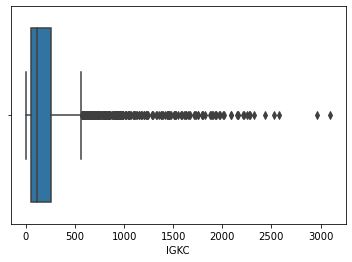

In [59]:
sns.boxplot(Sample3.to_df()[Sample3.to_df().sum().sort_values(ascending=False).index[:100][0]])

In [54]:
Y = Y.apply(lambda x: pd.cut(x, bins=[-0.01, 0.33, 0.66, 1], labels = [0, 1, 2]))
print("train_spots:");print(Y[0].value_counts())
print("test_spots:"); print(test_Y[0].value_counts())

train_spots:
0    3781
1      15
2       2
Name: 0, dtype: int64
test_spots:
0    2417
1      85
2      16
Name: 0, dtype: int64


## ST-Net

In [14]:
wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/"
biomarker_list_ST = ['COX6C', "MALAT1", 'TTLL12', "PABPC1", "GNAS", "HSP90AB1", "ATP1A1", "B2M", "FASN", "ACTG1", "HLA-B"]


X_ST = adata_all.obsm["Resnet50_Train_Features"]#pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_train.csv')#
#X_ST = X_ST.iloc[:,1:]
test_X_ST = adata_all_test.obsm["Resnet50_Test_Features"]#Sample3.obsm["Resnet50_Test_Features"]#pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Filtered_ST-Net.csv')#
#test_X_ST = test_X_ST.iloc[:,1:]

Y_ST = adata_all.to_df()#[adata_all.to_df().sum().sort_values(ascending=False).index[:10]] 
test_Y_ST = adata_all_test.to_df()#[adata_all.to_df().sum().sort_values(ascending=False).index[:10]] 
number_of_top_genes = 10
model = lgb.LGBMClassifier()#MLPClassifier(alpha=1, max_iter=7500)#

def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

Y_ST = Y_ST[biomarker_list_ST]#.iloc[:,:number_of_top_genes]#
genes = Y_ST.columns
MinMax_scaler_y_ST = preprocessing.MinMaxScaler(feature_range =(0, 1))
Y_ST = MinMax_scaler_y_ST.fit_transform(Y_ST) 
Y_ST = pd.DataFrame(data=Y_ST)
Y_ST = Y_ST.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.05], labels = [0, 1]))
#Y=Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))

test_Y_ST=test_Y_ST[biomarker_list_ST]#.iloc[:,:number_of_top_genes]#
test_Y_ST=MinMax_scaler_y_ST.fit_transform(test_Y_ST)
test_Y_ST=pd.DataFrame(data=test_Y_ST)
test_Y_ST = test_Y_ST.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.05], labels = [0, 1]))
#test_Y=test_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))

Y_ST = Y_ST.astype('int64')
test_Y_ST = test_Y_ST.astype('int64')

In [15]:
clf_2 = MultiOutputClassifier(model).fit(X_ST, Y_ST)

In [16]:
y_pred_test_1_ST = clf_2.predict_proba(test_X_ST)
y_pred_test_1_ST = np.array(y_pred_test_1_ST)

y_pred_test_2_ST = clf_2.predict(test_X_ST)
y_pred_test_2_ST = pd.DataFrame(y_pred_test_2_ST)

In [17]:
auroc_ST = []
for col in test_Y_ST:
    score_multi_ST = roc_auc_score(test_Y_ST[col], y_pred_test_2_ST[col])#, average='weighted'
    auroc_ST.append(score_multi_ST)
    
result_ST = pd.DataFrame()
result_ST["auroc"] = auroc_ST
result_ST.index = genes

In [18]:
result_ST.sort_values("auroc", ascending=False)

,auroc
COX6C,0.5
MALAT1,0.5
TTLL12,0.5
PABPC1,0.5
GNAS,0.5
HSP90AB1,0.5
ATP1A1,0.5
B2M,0.5
FASN,0.5
ACTG1,0.5


In [ ]:
from sklearn.metrics import confusion_matrix as cm
cm(test_Y_ST[1],y_pred_test_2_ST[1])

# Visualisation

In [156]:
BC23209_C1 = adata_all.obs[['BC23209_C1' in s for s in adata_all.obs.index]]

y_pred_test_2_ST_BC23209_C1 = y_pred_test_2_ST[0][:294]
test_Y_ST_BC23209_C1 = test_Y_ST[0][:294]

y_pred_test_2_ST_BC23209_C1.index = BC23209_C1.index
BC23209_C1["Cluster_Pred"] = y_pred_test_2_ST_BC23209_C1

test_Y_ST_BC23209_C1.index = BC23209_C1.index
BC23209_C1["Cluster_True"] = test_Y_ST_BC23209_C1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [157]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Output_Spots_Image/'
wd1 = 'D:/onkar/Projects/Project_Spt.Transcriptomics/29ntw7sh4r-2/data/'

def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1[Sample1['Cluster_True'] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Sample1[Sample1['Cluster_True'] == 1]
    Spot_vals1=Spot_vals1.values

    
    x = Spot_vals0[:,0].astype('int64')
    y = Spot_vals0[:,1].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()
    
    x1 = Spot_vals1[:,0].astype('int64')
    y1 = Spot_vals1[:,1].astype('int64')
    box1 = (x1,y1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()
    

    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 75,(255,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 75,(0,255,0), -1)

    cv2.imwrite(wd+"FASN-True-ST.png",image)

image = cv2.imread(wd1+"HE_BC23209_C1.jpg") 
Visualise(image, BC23209_C1)

In [158]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Output_Spots_Image/'
wd1 = 'D:/onkar/Projects/Project_Spt.Transcriptomics/29ntw7sh4r-2/data/'

def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1[Sample1['Cluster_Pred'] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Sample1[Sample1['Cluster_Pred'] == 1]
    Spot_vals1=Spot_vals1.values

    
    x = Spot_vals0[:,0].astype('int64')
    y = Spot_vals0[:,1].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()
    
    x1 = Spot_vals1[:,0].astype('int64')
    y1 = Spot_vals1[:,1].astype('int64')
    box1 = (x1,y1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()
    

    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 75,(255,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 75,(0,255,0), -1)

    cv2.imwrite(wd+"FASN-Pred-ST.png",image)

image = cv2.imread(wd1+"HE_BC23209_C1.jpg") 
Visualise(image, BC23209_C1)

# Save all models

In [ ]:
joblib.dump(clf_1, wd+'ResNet50-LGBM_biomarker_gene.pkl')
joblib.dump(clf, wd+'ResNet50-LGBM_biomarker_gene.pkl')
joblib.dump(clf_2, wd+'ResNet50-LGBM_biomarker_gene.pkl')

## LIME Interpretability - Interpretation.py

In [5]:
def LGBM(train_X, train_Y): 
    train_Y = train_Y.iloc[:,:3]
    Standard_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
    train_Y = pd.DataFrame(data = Standard_scaler_y.fit_transform(train_Y))
    train_Y=train_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.15, random_state = 0)
    clf = MultiOutputClassifier(lgb.LGBMClassifier()).fit(X_train, y_train) #LGBM model is fit for X and Y
    return clf

train_X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/features_flatten_train.csv') #Train_Features Sample1.obsm["Resnet50_Train_Features"] #
train_X = train_X.iloc[:,1:]
train_Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #pd.read_csv('Breast_1A_500_top.csv') #Sample1.to_df() #
#train_Y = train_Y.drop(['Sno'], axis=1)
Model_LGBM = LGBM(train_X, train_Y)

resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")
gene_list = train_Y.columns.tolist()[:3]

    
def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[i]

def pred_label(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((1, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
#     annotation_h = np.clip(annotation_h, a_min=0, a_max=255)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=80).astype(np.int)
    return im_nuclei_seg_mask

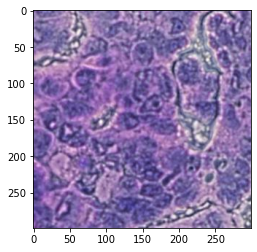

In [5]:
plt.imshow(Image.open('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg'))

In [13]:
gene_list = train_Y.columns.tolist()[:3]
def model_predict_gene(gene):
    i = gene_list.index(gene)
    def combine_model_predict(tile):
        feature = resnet_model.predict(tile)
        feature = feature.reshape((10, 2048))
        prediction = Model_LGBM.predict_proba(feature)
        return prediction[i]
    return combine_model_predict
model_predict_gene("COX6C")

<function __main__.model_predict_gene.<locals>.combine_model_predict(tile)>

## Quickshift-LIME

<ipython-input-5-42ea33ecc558>:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=80).astype(np.int)


  0%|          | 0/100 [00:00<?, ?it/s]

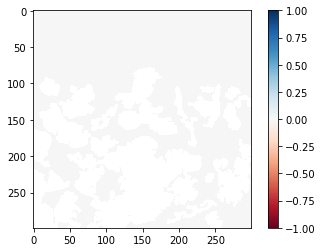

In [15]:
"""def pred_label(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((1, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction
#gene_list = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:200]].columns
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")"""

#i = gene_list.get_loc(input('Enter Gene Name :'))
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model_predict_gene("COX6C"), segmentation_fn= watershed_segment, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -1, vmax = 1)
plt.colorbar()
#print(pred_label(images))

In [ ]:
i = gene_list.get_loc(input('Enter Gene Name :'))
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= None, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
print(pred_label(images))

In [ ]:
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[2]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Watershed-LIME

In [ ]:
def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
#     annotation_h = np.clip(annotation_h, a_min=0, a_max=255)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=80).astype(np.int)
    return im_nuclei_seg_mask

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)


i = gene_list.get_loc(input('Enter Gene Name :'))
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[0].astype('double'), 
                                         combine_model_predict, 
                                         top_labels=3, num_samples=100,
                                         segmentation_fn=watershed_segment)

dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Trail

In [ ]:
def LGBM(train_X, train_Y): 
    train_Y = train_Y['SAMD10'].to_numpy().reshape(3798,1)
    Standard_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
    train_Y = pd.DataFrame(data = Standard_scaler_y.fit_transform(train_Y))
    train_Y=train_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.15, random_state = 0)
    clf = MultiOutputClassifier(lgb.LGBMClassifier()).fit(X_train, y_train) #LGBM model is fit for X and Y
    return clf

train_X = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/features_flatten_train.csv') #Train_Features Sample1.obsm["Resnet50_Train_Features"] #
train_X = train_X.iloc[:,1:]
train_Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:10000]] #pd.read_csv('Breast_1A_500_top.csv') #
#train_Y = train_Y.drop(['Sno'], axis=1)
Model_LGBM = LGBM(train_X, train_Y)


def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[i]

resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")
def pred_label(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((1, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
#     annotation_h = np.clip(annotation_h, a_min=0, a_max=255)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=80).astype(np.int)
    return im_nuclei_seg_mask

### COX6C

In [ ]:
gene_list = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]].columns
i = gene_list.get_loc(input('Enter Gene Name :'))
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= None, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
print(pred_label(images))

In [ ]:
def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
#     annotation_h = np.clip(annotation_h, a_min=0, a_max=255)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=80).astype(np.int)
    return im_nuclei_seg_mask

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)


i = gene_list.get_loc(input('Enter Gene Name :'))
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[0].astype('double'), 
                                         combine_model_predict, 
                                         top_labels=3, num_samples=100,
                                         segmentation_fn=watershed_segment)

dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### GFRA1

In [ ]:
def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[0]

images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= None, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[0]

images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= watershed_segment, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### NAPA

In [ ]:
def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[0]

images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= None, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[0]

images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= watershed_segment, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### SAMD10

In [ ]:
def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction[0]

images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= watershed_segment, top_labels=3, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Spatial Autocorrelation

In [13]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os

In [45]:
gene = "COX6C"

In [19]:
test_X = pd.read_csv("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Resnet_unnorm_test.csv").iloc[:,1:]
Model = joblib.load("ResNet50-LGBM_200_unnorm_updated.pkl")
y = Model.predict(test_X)

In [5]:
Sample2.obsm["gpd"] = gpd.GeoDataFrame(Sample2.obs,
                                             geometry=gpd.points_from_xy(
                                                 Sample2.obs.imagecol, 
                                                 Sample2.obs.imagerow))
Sample2.obsm["gpd"]

,in_tissue,array_row,array_col,sum_counts,imagecol,imagerow,tile_path,geometry
AAACAACGAATAGTTC-1,1,0,16,17367.0,6080,3722,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (6080.000 3722.000)
AAACAAGTATCTCCCA-1,1,50,102,9873.0,17782,15632,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (17782.000 15632.000)
AAACAATCTACTAGCA-1,1,3,43,29133.0,9763,4445,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (9763.000 4445.000)
AAACACCAATAACTGC-1,1,59,19,31487.0,6447,17734,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (6447.000 17734.000)
AAACAGAGCGACTCCT-1,1,14,94,10707.0,16716,7079,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (16716.000 7079.000)
...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,22138.0,9587,17507,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (9587.000 17507.000)
TTGTTTCATTAGTCTA-1,1,60,30,24764.0,7947,17976,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (7947.000 17976.000)
TTGTTTCCATACAACT-1,1,45,27,11746.0,7549,14413,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (7549.000 14413.000)
TTGTTTGTATTACACG-1,1,73,41,30192.0,9439,21068,D:\onkar\Projects\Project_Spt.Transcriptomics\...,POINT (9439.000 21068.000)


In [7]:
test_Y = Sample2.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 

Y=Y.iloc[:,:200]
MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
Y = MinMax_scaler_y.fit_transform(Y) 
Y = pd.DataFrame(data=Y)
Y=Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))

#test_Y.drop(['Sno'],axis=1,inplace=True)
test_Y=test_Y.iloc[:,:200]
test_Y=MinMax_scaler_y.transform(test_Y)
test_Y=pd.DataFrame(data=test_Y)
test_Y=test_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
    
w = Queen.from_dataframe(Sample2.obsm["gpd"])

In [39]:
x = test_Y[[0]].values
Sample2.obsm["gpd"]["gc_{}".format("COX6C")] = x
#y = pd.DataFrame(y[:,:1])
Sample2.obsm["gpd"]["pred_{}".format("COX6C")] = y.values
tissue_image = Sample2.uns["spatial"]["block2"]["images"]["fulres"]

In [40]:
moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)

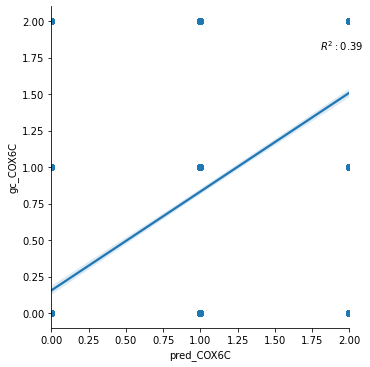

In [46]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g

plot_correlation(Sample2.obsm["gpd"],
                 "pred_{}".format(gene),
                 "gc_{}".format(gene))
plt.show()

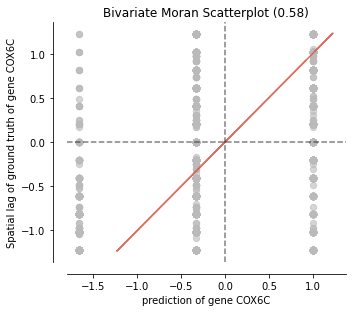

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
moran_scatterplot(moran_bv, ax=ax)
ax.set_xlabel('prediction of gene {}'.format(gene))
ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
plt.tight_layout()
plt.show()

IndexError: Replacement index 0 out of range for positional args tuple

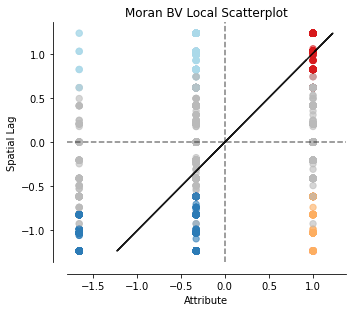

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
moran_scatterplot(moran_loc_bv, p=0.05, ax=ax)
ax.set_xlabel('prediction of gene {}'.format())
ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
plt.tight_layout()
plt.show()

In [49]:
def plot_choropleth(gdf, 
                    attribute_1,
                    attribute_2,
                    bg_img,
                    alpha=0.5,
                    scheme='Quantiles', 
                    cmap='YlGnBu', 
                    legend=True):
    
    fig, axs = plt.subplots(2,1, figsize=(5, 8),
                            subplot_kw={'adjustable':'datalim'})
    
    # Choropleth for attribute_1
    gdf.plot(column=attribute_1, scheme=scheme, cmap=cmap,
             legend=legend, legend_kwds={'loc': 'upper left',
                                         'bbox_to_anchor': (0.92, 0.8)},
             ax=axs[0], alpha=alpha, markersize=2)
    
    axs[0].imshow(bg_img)
    axs[0].set_title('choropleth plot for {}'.format(attribute_1), y=0.8)
    axs[0].set_axis_off()
    
    # Choropleth for attribute_2
    gdf.plot(column=attribute_2, scheme=scheme, cmap=cmap,
             legend=legend, legend_kwds={'loc': 'upper left',
                                         'bbox_to_anchor': (0.92, 0.8)},
             ax=axs[1], alpha=alpha, markersize=2)
    
    axs[1].imshow(bg_img)
    axs[1].set_title('choropleth plot for {}'.format(attribute_2), y=0.8)
    axs[1].set_axis_off()
    
    plt.tight_layout()
    
    return fig, ax

C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


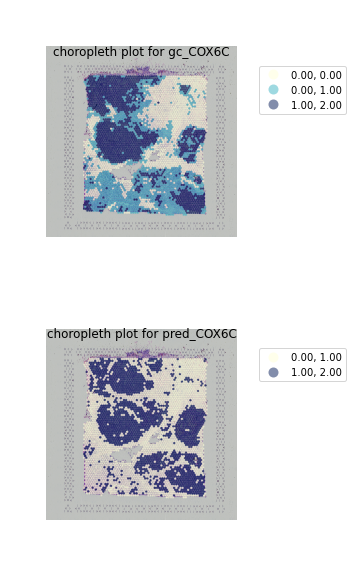

In [51]:
plot_choropleth(Sample2.obsm["gpd"], 
                "gc_{}".format(gene),
                "pred_{}".format(gene),
                tissue_image)
plt.show()

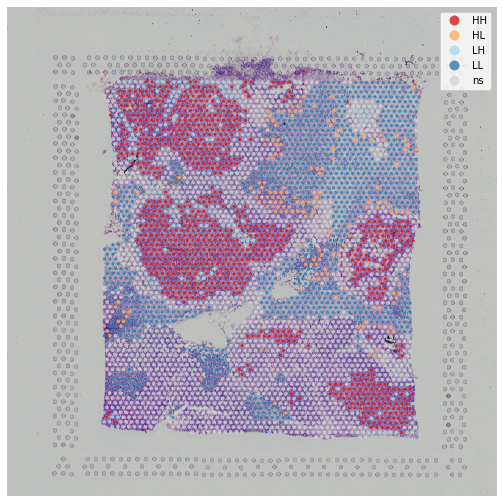

In [54]:
lisa_cluster(moran_loc_bv, Sample2.obsm["gpd"], p=0.05, 
             figsize = (9,9), markersize=12, **{"alpha":0.8})
plt.imshow(Sample2.uns["spatial"]["block2"]["images"]["fulres"])
plt.show()

C:\Users\Onkar\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
C:\Users\Onkar\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Onkar\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MultiOutputClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


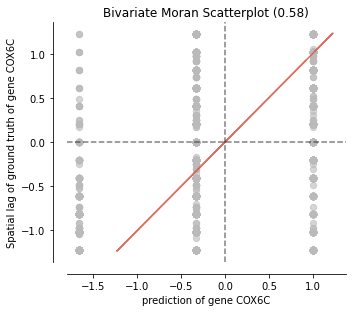

C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Onkar\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


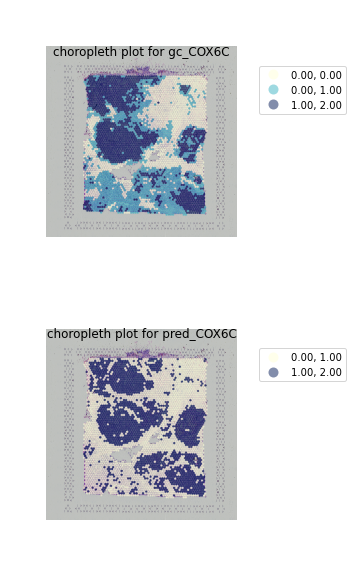

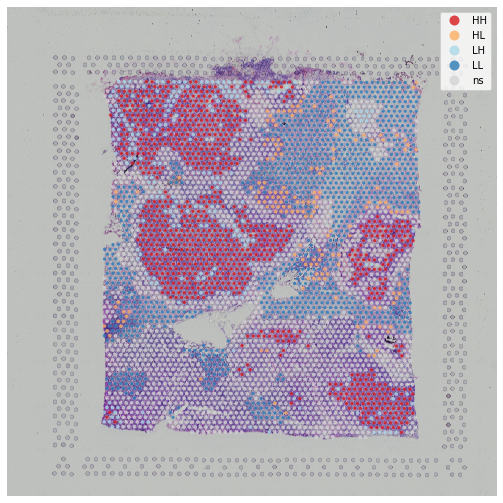

In [3]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os


def Spatial_AutoCorr(Sample1, Sample2, Model, test_X, gene, wd):
    Sample2.obsm["gpd"] = gpd.GeoDataFrame(Sample2.obs,
                                                 geometry=gpd.points_from_xy(
                                                     Sample2.obs.imagecol, 
                                                     Sample2.obs.imagerow))

    test_Y = Sample2.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
    Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
    gene_list = Y.columns.tolist()

    Y=Y.iloc[:,:200]
    MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
    Y = MinMax_scaler_y.fit_transform(Y) 
    Y = pd.DataFrame(data=Y)
    Y=Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))

    test_Y=test_Y.iloc[:,:200]
    test_Y=MinMax_scaler_y.transform(test_Y)
    test_Y=pd.DataFrame(data=test_Y)
    test_Y=test_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))

    w = Queen.from_dataframe(Sample2.obsm["gpd"])

    y = Model.predict(test_X)
    i = gene_list.index(gene)+1
    y = pd.DataFrame(y[:,:i])

    x = test_Y[[0]].values
    Sample2.obsm["gpd"]["gc_{}".format(gene)] = x
    Sample2.obsm["gpd"]["pred_{}".format(gene)] = y.values
    tissue_image = Sample2.uns["spatial"]["block2"]["images"]["fulres"]
    
    
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)

    fig, ax = plt.subplots(figsize=(5,5))
    moran_plot = moran_scatterplot(moran_bv, ax=ax)
    ax.set_xlabel('prediction of gene {}'.format(gene))
    ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
    plt.tight_layout()
    plt.show()


    def plot_choropleth(gdf, 
                        attribute_1,
                        attribute_2,
                        bg_img,
                        alpha=0.5,
                        scheme='Quantiles', 
                        cmap='YlGnBu', 
                        legend=True):

        fig, axs = plt.subplots(2,1, figsize=(5, 8),
                                subplot_kw={'adjustable':'datalim'})

        # Choropleth for attribute_1
        gdf.plot(column=attribute_1, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[0], alpha=alpha, markersize=2)

        axs[0].imshow(bg_img)
        axs[0].set_title('choropleth plot for {}'.format(attribute_1), y=0.8)
        axs[0].set_axis_off()

        # Choropleth for attribute_2
        gdf.plot(column=attribute_2, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[1], alpha=alpha, markersize=2)

        axs[1].imshow(bg_img)
        axs[1].set_title('choropleth plot for {}'.format(attribute_2), y=0.8)
        axs[1].set_axis_off()

        plt.tight_layout()

        return fig, ax

    choropleth_plot = plot_choropleth(Sample2.obsm["gpd"], "gc_{}".format(gene),"pred_{}".format(gene),tissue_image)
    plt.show()

    lisa_cluster(moran_loc_bv, Sample2.obsm["gpd"], p=0.05, 
                 figsize = (9,9), markersize=12, **{"alpha":0.8})
    lisa_plot = plt.imshow(Sample2.uns["spatial"]["block2"]["images"]["fulres"])
    plt.show()
    return moran_plot, choropleth_plot, lisa_plot



gene = "COX6C"
Sample1 = Sample1
Sample2 = Sample2
wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
test_X = pd.read_csv(wd+"Resnet_unnorm_test.csv").iloc[:,1:] 
Model = joblib.load(wd+"ResNet50-LGBM_200_unnorm_updated.pkl")

a,b,c = Spatial_AutoCorr(Sample1, Sample2, Model, test_X, gene, wd)